In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import shap
%matplotlib inline

seed(888)

# 1 Load data from "2. Preprocessing"

In [21]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("2_brain_test.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("2_main_test.pkl")
main_train = pd.read_pickle("2_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

## 1.1 Chose training set with or without Excluded people

In [22]:
brain_train = brain_train[main_train["Excluded"]==0]
main_train = main_train[main_train["Excluded"]==0]

# 2 Delte rows with nan in any brain segmentation

In [23]:
nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 50
Number of people with missing brain values in test set: 20


# 3 BrainAge with different segmentations

## 3.1 A2009s Segmentation

The MAE for cross-validation (Ridge): 4.1666473995278555
The MAE for testing set using Ridge: 4.22647248030076
Index(['area_of_scalcarine_left_hemisphere_f27372_2_0',
       'volume_of_scalcarine_left_hemisphere_f27520_2_0',
       'volume_of_gfrontsup_left_hemisphere_f27492_2_0',
       'volume_of_gscingulant_right_hemisphere_f27704_2_0',
       'area_of_gfrontsup_left_hemisphere_f27344_2_0',
       'volume_of_sparietooccipital_right_hemisphere_f27763_2_0',
       'volume_of_scentral_left_hemisphere_f27521_2_0',
       'volume_of_latfispost_right_hemisphere_f27739_2_0',
       'area_of_scalcarine_right_hemisphere_f27594_2_0',
       'volume_of_scalcarine_right_hemisphere_f27742_2_0'],
      dtype='object')
[-1.59242682  1.59611842  1.61741918 -1.67451513 -1.75870644  1.7660086
  1.85731036  2.15445938 -2.37544044  2.38134993]


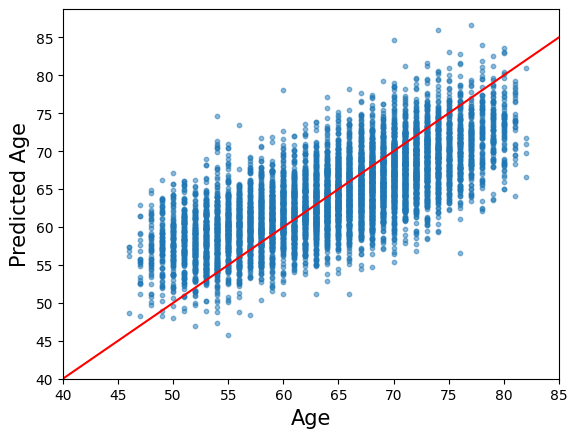

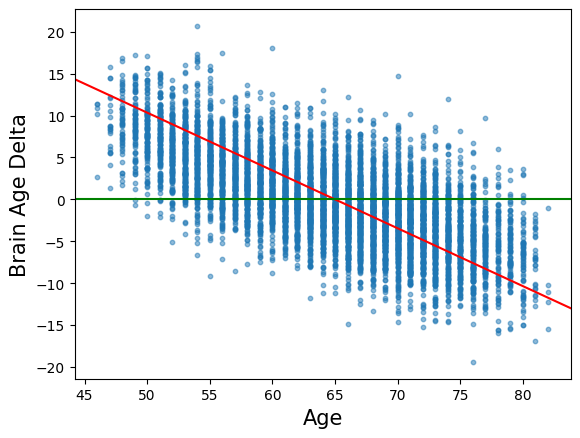

In [24]:
# select segmentation
X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

# different models for test data
#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# Spearman rank order correlations
# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))

coeff = np.asarray(model_Ridge.coef_)
coeffabs = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()


### 3.1.1 Correction

Coefficient and Intercept: 0.5448015841947859 29.32366759218892


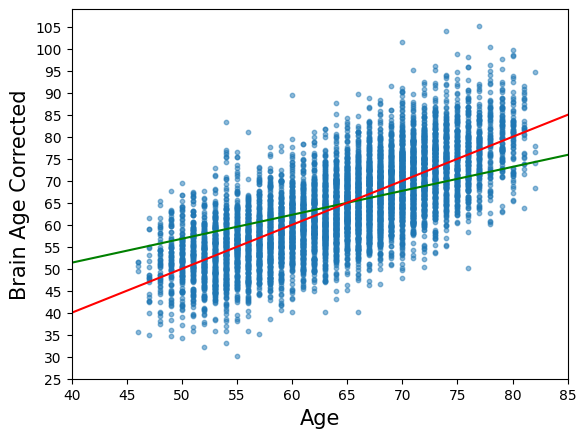

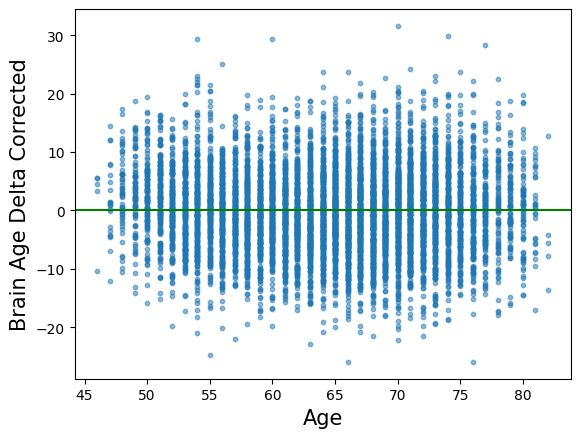

In [25]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
plt.axline((65,65), slope=coef, color="g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## 3.2 ASEG Segmentation

In [26]:
# select Freesurfer ASEG for training data
whole_brain = brain_train.iloc[:,27:70:2]
left_hemi = brain_train.iloc[:,103:134:2]
right_hemi = brain_train.iloc[:,165:196:2]
age = brain_train["Age"]
ASEG_train = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

# select Freesurfer ASEG for testing data
whole_brain = brain_test.iloc[:,27:70:2]
left_hemi = brain_test.iloc[:,103:134:2]
right_hemi = brain_test.iloc[:,165:196:2]
age = brain_test["Age"]
ASEG_test = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

X_train = ASEG_train.iloc[:,:-1]
Y_train = ASEG_train.iloc[:,-1]
X_test = ASEG_test.iloc[:,:-1]
Y_test = ASEG_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))



# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
model = RidgeCV(alphas = alpha_parameters)
#model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

coeff = np.asarray(model.coef_)
coeffabs = np.asarray(abs(model.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

The MAE for cross-validation (Ridge): 4.160027897883571
The MAE for testing set: 4.264119889717584
Index(['volume_of_ventriclechoroid_whole_brain_f26522_2_0',
       'volume_of_totalgray_whole_brain_f26518_2_0',
       'volume_of_supratentorial_whole_brain_f26519_2_0',
       'volume_of_lateralventricle_right_hemisphere_f26585_2_0',
       'volume_of_subcortgray_whole_brain_f26517_2_0',
       'volume_of_supratentorialnotvent_whole_brain_f26520_2_0',
       'volume_of_brainsegnotventsurf_whole_brain_f26516_2_0',
       'volume_of_lateralventricle_left_hemisphere_f26554_2_0',
       'volume_of_brainsegnotvent_whole_brain_f26515_2_0',
       'volume_of_brainseg_whole_brain_f26514_2_0'],
      dtype='object')
[  13.44832739   19.79406964  -22.36068323  -30.69844126   32.03573772
  -32.65534304   33.74648138  -35.5750079  -425.30294572  440.97734503]


### 3.2.1 Correction

In [27]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_2 = vfunc(y_pred)
corr_brainage_delta_2 = corr_brainage_2-Y_test


# plt.figure()
# plt.scatter(Y_test, corr_brainage_2, alpha=0.5, s=10)
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_2, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.5359367079691696 29.813430922569097


## 3.3 Desikan Pial Segmentation

In [28]:
X_train = brain_train.iloc[:,845:976:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,845:976:2]
Y_test = brain_test.iloc[:,-1]

X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
model = RidgeCV(alphas = alpha_parameters)
#model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

coeff = np.asarray(model.coef_)
coeffabs = np.asarray(abs(model.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# plt.figure()
# plt.scatter(Y_test, y_pred, alpha=0.5, s=10)
# plt.axline((60,60), slope=1, color='r')
# plt.xticks(range(40,90,5))
# plt.yticks(range(40,90,5))
# plt.ylabel('Predicted Age', fontsize = 15)
# plt.xlabel('Age', fontsize = 15)
# plt.show()

# plt.figure()
# plt.scatter(Y_test,brain_age_delta, alpha=0.5, s=10)
# plt.axline((65,0), slope=-0.69, color="r")
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

The MAE for cross-validation (Ridge): 5.679842738687717
The MAE for testing set: 5.8183275076753995
Index(['area_of_inferiortemporal_left_hemisphere_f26931_2_0',
       'area_of_middletemporal_left_hemisphere_f26937_2_0',
       'area_of_inferiorparietal_left_hemisphere_f26930_2_0',
       'area_of_supramarginal_left_hemisphere_f26953_2_0',
       'area_of_superiorparietal_left_hemisphere_f26951_2_0',
       'area_of_lateraloccipital_left_hemisphere_f26933_2_0',
       'area_of_rostralmiddlefrontal_left_hemisphere_f26949_2_0',
       'area_of_superiorfrontal_left_hemisphere_f26950_2_0',
       'area_of_totalsurface_right_hemisphere_f26956_2_0',
       'area_of_totalsurface_left_hemisphere_f26923_2_0'],
      dtype='object')
[-3.57273402 -3.59536167 -3.8169417  -3.87088894 -4.0861323  -4.17943622
 -4.62960509 -5.74138658 18.61520481 48.11867213]


### 3.3.1 Correction

In [29]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_3 = vfunc(y_pred)
corr_brainage_delta_3 = corr_brainage_3-Y_test


# plt.figure()
# plt.scatter(Y_test, corr_brainage_3, alpha=0.5, s=10)
# plt.ylabel("Brain Age Corrected", fontsize = 15)
# plt.axline((60,60), slope=1, color='r')
# plt.xlabel("Age", fontsize = 15)
# plt.xticks(range(40,90,5))
# plt.yticks(range(25,110,5))
# plt.show()

# plt.figure()
# plt.scatter(Y_test, corr_brainage_delta_3, alpha=0.5, s=10)
# plt.axline((60,0),slope=0, color = "g")
# plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
# plt.xlabel("Age", fontsize = 15)
# plt.show()

Coefficient and Intercept: 0.17772390334409296 52.98798368847515


## 3.4 All Brain Variables

The MAE for cross-validation (Ridge): 3.0844957990830744
Index(['volume_of_subcortgray_whole_brain_f26517_2_0',
       'greywhite_contrast_in_precuneus_right_hemisphere_f27048_2_0',
       'volume_of_vlp_left_hemisphere_f26686_2_0',
       'volume_of_midbrain_whole_brain_f26719_2_0',
       'greywhite_contrast_in_inferiorparietal_right_hemisphere_f27031_2_0',
       'greywhite_contrast_in_precuneus_left_hemisphere_f27013_2_0',
       'volume_of_ventraldc_right_hemisphere_f26596_2_0',
       'volume_of_brainstem_whole_brain_f26526_2_0',
       'volume_of_wholebrainstem_whole_brain_f26720_2_0',
       'volume_of_pons_whole_brain_f26717_2_0'],
      dtype='object')
[ 0.78648642 -0.81036031 -0.88661813  0.89474519  0.92725936 -0.92755472
 -0.98656591 -1.03887019  1.06380567  1.39833379]


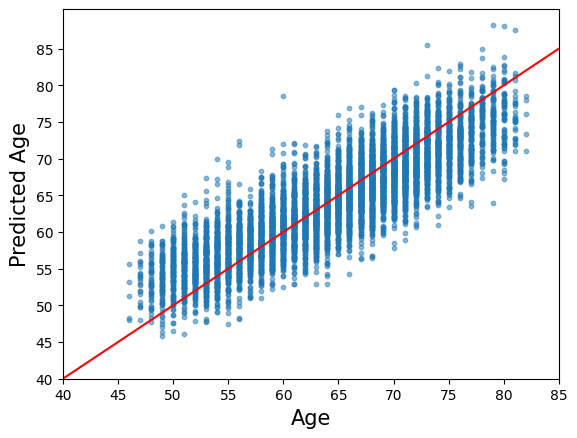

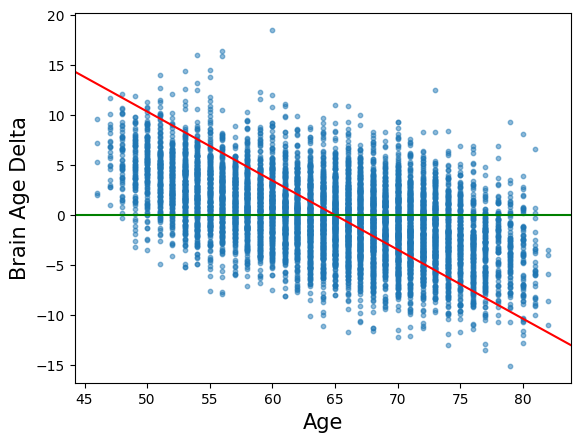

In [30]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
X_train_std = stats.zscore(X_train)
X_test_std = stats.zscore(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000, tol=1e-2)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)


coeff = np.asarray(model_Ridge.coef_)
coeffabs = np.asarray(abs(model_Ridge.coef_))
top_10_coefficients = np.argsort(coeffabs)[-10:]
print(X_train_std.iloc[:,top_10_coefficients].columns)
print(coeff[top_10_coefficients])

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# # get mean absolute error (MAE)
# print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
# print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
# print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))

# Spearman rank order correlations
# print("The Spearman r for Ridge vs Lasso:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_Lasso))
# print("The Spearman r for Ridge vs SVR:", stats.spearmanr(brain_age_delta_Ridge, brain_age_delta_SVR))
# print("The Spearman r for SVR vs Lasso:", stats.spearmanr(brain_age_delta_SVR, brain_age_delta_Lasso))



plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

### 3.4.1 Correction

Coefficient and Intercept: 0.7597481278092065 15.475900461133776
The MAE for testing set corrected: 3.5218155530622197


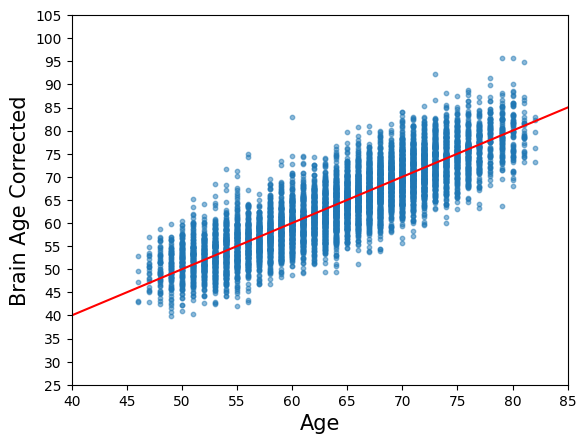

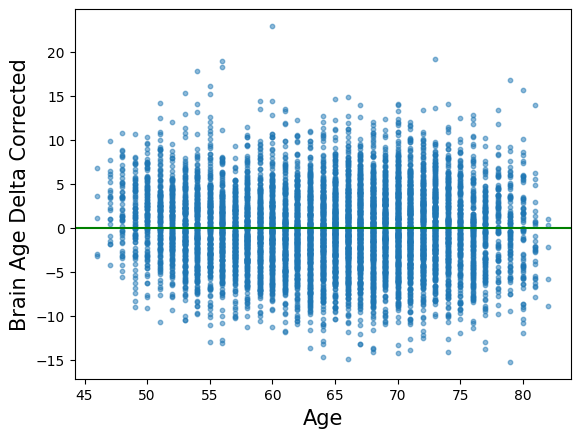

In [31]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred_Ridge)
corr_brainage_delta_4 = corr_brainage_4-Y_test

print("The MAE for testing set corrected:", mean_absolute_error(Y_test,corr_brainage_4))

plt.figure()
plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

# 4 Add BrainAge Deltas to main_test

In [32]:
main_test["BADA2009"] = corr_brainage_delta_1
main_test["BADASEG"] = corr_brainage_delta_2
main_test["BADDesikan"] = corr_brainage_delta_3
main_test["BADAll"] = corr_brainage_delta_4

# 5 Pickle data for next script

In [33]:
# pickle results
main_test.to_pickle("3_main_test.pkl")
main_train.to_pickle("3_main_train.pkl")
brain_test.to_pickle("3_brain_test.pkl")
brain_train.to_pickle("3_brain_train.pkl")